In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy.random import rand, randn, choice, permutation
from scipy.linalg import hadamard

import torch
import torch.nn.functional as F

import tensorly as tl
from tensorly import decomposition
from tensorly.decomposition import parafac
from scipy import linalg

In [2]:
## Defining Measurement Matrices ##

## Returns gaussian mx(unweighted) of dimensionn m*N
def gaussian_mx(m,N): 
    A = np.random.normal(0.0, 1.0, [m, N])
    return A

def hadamard_mx(m,N):
    A = hadamard(N)
    l = permutation(np.range(N))
    return A[l[:m],:]

In [3]:
def vectorize_tl(X): ##Vectorisation for tensors
    x=X.numpy()
    x=x.reshape(-1)
    return x

def vectorize_np(X):  ##Vecorisation for numpy arrays
    x=X
    x=x.reshape(-1)
    return x

In [4]:
## Thresholding operators #########

def sparse_vect(x,s): ## s-sparse approximation
    
    x_1 = np.abs(x)
    index = np.flip(np.argsort(x_1))[:s]
    l = np.zeros(np.shape(x)[0])
    l[index] = x[index]

    return l

def sparse_vect_random(x,s):  ##Randomy selects indices to sparsify
    
    index = np.random.choice(np.shape(x)[0], s, replace=False)
    l = np.zeros(np.shape(x)[0])
    l[index] = x[index]
    
    return l

def random_low_rank_HOSVD(n,r,eps = 0.1):
    C=np.random.normal(0,1,size=r)+eps
    C=tl.tensor(C)
    C.shape
    X=C

    U=[]
    for i in range(len(n)):
        M=np.random.normal(0,1,size=(n[i],n[i]))+eps
        u,sigma,v=np.linalg.svd(M)
        U.append(u[:,0:r[i]])

    for i in range(len(n)):
        X=tl.tenalg.mode_dot(X,U[i],i)
    return X

def random_low_rank_CP(n,r,eps = 0.1):   #### CP Rank r
    #torch.manual_seed(0)
    #np.random.seed(0)
    
    L = []
    for i in range(0,len(n)):
        C=np.random.normal(0,1,size=(n[i],r))+eps
        L = L + [C]
    
    X = np.zeros(n)
    for i in range(r):
        U_r = np.array(L[0])[:,i]
        for j in range(1, len(n)):
            prod = np.array(L[j])[:,i]
            U_r = np.multiply.outer(U_r,prod)
        X = X + U_r
        
    C=tl.tensor(X) #Changing data frame to tensor
    C.shape
    return C

def HOSVD_rank_app(tensor,r): ## HOSVD rank-r approximation
    
    core, factors = tl.decomposition.tucker(tensor.numpy(), r) #Decomposition function is used 
    answer = torch.tensor(tl.tucker_to_tensor([core, factors]))
    
    return answer

def CP_rank_app(tensor,r):  ## CP rank-r approximation
    
    factors = parafac(tl.tensor(tensor), rank=r)
    answer = tl.cp_to_tensor(factors)
    
    return answer

In [5]:
def TIHT_CP(AA,yy,X,r,lamda = 1, itr = 100): 
    
    n = np.shape(X)
    X_ravel = np.ravel(X)
    
    error = np.zeros(itr)
    
    vXX = torch.randn(n)*0 ##Random Initialisation

    for j in range(itr):
    
        WW = np.array(vectorize_np(vXX)) + lamda*np.matmul(AA.T, (yy - np.matmul(AA, np.array(vectorize_np(vXX)))))
        WW = torch.reshape(torch.tensor(WW), n)
        vXX = CP_rank_app(WW,r)
        error[j] = np.linalg.norm(vectorize_np(vXX)- X_ravel)/np.linalg.norm(X_ravel)
        
    return vXX, error

In [6]:
def TIHT_HOSVD(AA,yy,X,r,lamda = 1, itr = 100): 
    
    n = np.shape(X)
    X_ravel = np.ravel(X)
    
    error = np.zeros(itr)
    
    vXX = torch.randn(n)*0

    for j in range(itr):
    
        WW = np.array(vectorize_tl(vXX)) + lamda* np.matmul(AA.T, (yy - np.matmul(AA, np.array(vectorize_tl(vXX)))))
        WW = torch.reshape(torch.tensor(WW), n)
        vXX = HOSVD_rank_app(WW,r)
        error[j] = np.linalg.norm(vectorize_tl(vXX)- X_ravel)/np.linalg.norm(X_ravel)
        
    return vXX, error

In [7]:
def KZIHT(A,b,x,s,gamma=1,itr=100): ## Selecting rows with replacement, gamma-step size for Kaczmarz
    
    error = np.zeros(itr)
    m = np.shape(A)[0]
    y = np.zeros(np.shape(x)[0])
    
    for k in range(itr): # Outer iteration for IHT updates
        for j in range(m): #Inner iteration for Kaczmarz updates
            
            t = np.random.randint(m)
            a = A[t,:]
            y = y + gamma*(b[t] - a@y)*a/(np.linalg.norm(a)**2)
                           
        y = sparse_vect(y,s)
        error[k] = np.linalg.norm(y-x)/np.linalg.norm(x)
                             
    return y,error

In [8]:
def KZIHT_RR(A,b,x,s,gamma=1,itr=100): ## Selecting rows with replacement, gamma-step size for Kaczmarz
    
    error = np.zeros(itr)
    m = np.shape(A)[0]
    y= np.zeros(np.shape(x)[0])
    
    for k in range(itr): # Outer iteration for IHT updates
        
        t = permutation(np.arange(m))
        
        for j in range(m): #Inner iteration for Kaczmarz updates
            
            a = A[t[j],:]
            y = y + gamma*(b[t[j]] - a@y)*a/(np.linalg.norm(a)**2)
                           
        y = sparse_vect(y,s)
        error[k] = np.linalg.norm(y-x)/np.linalg.norm(x)
        
    return y,error

In [9]:
def KZIHT_HOSVD(A,b,X,n,r,gamma = 1, itr = 100):
    
    error = np.zeros(itr)
    m = np.shape(A)[0]
    
    n = np.shape(X)
    x = np.ravel(X)
    
    y = np.zeros(np.shape(x)[0])    
    
    for k in range(itr): # Outer iteration for IHT updates
        for j in range(m): #Inner iteration for Kaczmarz updates
            
            t = np.random.randint(m)
            a = A[t,:]
            y = y + gamma*(b[t] - a@y)*a/(np.linalg.norm(a)**2)
                           
        WW = torch.reshape(torch.tensor(y), n)
        y = vectorize_tl(HOSVD_rank_app(WW,r))
        error[k] = np.linalg.norm(y-x)/np.linalg.norm(x)
                             
    return y,error

In [10]:
def KZPT_HOSVD_RR(A,b,X,n,r, period = 1,gamma = 1, itr = 100):
    
    error = np.zeros(itr)
    m = np.shape(A)[0]
    
    n = np.shape(X)
    x = np.ravel(X)
    
    y = np.zeros(np.shape(x)[0])    
    t = permutation(np.arange(m))
            
    for k in range(itr): # Outer iteration for IHT updates
        
        for j in range(m): #Inner iteration for Kaczmarz updates
            
            a = A[t[j],:]
            y = y + gamma*(b[t[j]] - a@y)*a/(np.linalg.norm(a)**2)
                                     
            if (j+1)%period == 0:
                WW = torch.reshape(torch.tensor(y), n)
                y = vectorize_tl(HOSVD_rank_app(WW,r))
                
        error[k] = np.linalg.norm(vectorize_np(y)-x)/np.linalg.norm(x)
                             
    return y,error

In [11]:
def KZIHT_HOSVD_RR(A,b,X,n,r,gamma = 1, itr = 100):
    
    error = np.zeros(itr)
    m = np.shape(A)[0]
    
    n = np.shape(X)
    x = np.ravel(X)
    
    y = np.zeros(np.shape(x)[0])    
            
    for k in range(itr): # Outer iteration for IHT updates
        
        t = permutation(np.arange(m))
        
        for j in range(m): #Inner iteration for Kaczmarz updates
            
            a = A[t[j],:]
            y = y + gamma*(b[t[j]] - a@y)*a/(np.linalg.norm(a)**2)
                                     
        WW = torch.reshape(torch.tensor(y), n)
        y = vectorize_tl(HOSVD_rank_app(WW,r))
        error[k] = np.linalg.norm(vectorize_np(y)-x)/np.linalg.norm(x)
                             
    return y,error


In [12]:
def KZIHT_HOSVD_DET(A,b,X,n,r,gamma = 1, itr = 100):
    
    error = np.zeros(itr)
    m = np.shape(A)[0]
    
    n = np.shape(X)
    x = np.ravel(X)
    
    y = np.zeros(np.shape(x)[0])    
            
    for k in range(itr): # Outer iteration for IHT updates
        
        t = np.arange(m)
        
        for j in range(m): #Inner iteration for Kaczmarz updates
            
            a = A[t[j],:]
            y = y + gamma*(b[t[j]] - a@y)*a/(np.linalg.norm(a)**2)
                                     
        WW = torch.reshape(torch.tensor(y), n)
        y = vectorize_tl(HOSVD_rank_app(WW,r))
        error[k] = np.linalg.norm(vectorize_np(y)-x)/np.linalg.norm(x)
                             
    return y,error

In [13]:
def row_normalised_mx(A,b):
    B = np.zeros(np.shape(A))
    c = np.zeros(np.shape(b))
    for i in range(np.shape(A)[0]):
        B[i,:] = A[i,:]/np.linalg.norm(A[i,:])
        c[i] = b[i]/np.linalg.norm(A[i,:])
    return B,c

In [92]:
n = 125
n_dim = [5,5,5]
r = [2,2,2]
itr = 250
m = 50

A_1 = np.random.normal(0.0,1.0,(n_dim[0],m))
A_2 = np.random.normal(0.0,1.0,(n_dim[1],m))
A_3 = np.random.normal(0.0,1.0,(n_dim[2],m))
A_4 = linalg.khatri_rao(A_1,linalg.khatri_rao(A_2,A_3))
A = A_4.T

In [93]:
x = A[0,:]
X = torch.reshape(torch.tensor(x), [5,5,5])
b = A@x
A_1,b_1 = row_normalised_mx(A,b)

In [94]:
y_IHT,error_IHT = TIHT_HOSVD(A,b,X,r,lamda=0.2*1/m,itr = 1000)

In [95]:
error_IHT

array([0.71004108, 0.54706937, 0.42641317, 0.33769744, 0.2725939 ,
       0.22474889, 0.18945101, 0.16322805, 0.14352902, 0.12850407,
       0.11684356, 0.1076378 , 0.10025029, 0.09422427, 0.08922952,
       0.08503062, 0.08146112, 0.07840095, 0.07575925, 0.07346347,
       0.07145339, 0.06967823, 0.0680954 , 0.0666697 , 0.0653726 ,
       0.06418139, 0.0630782 , 0.06204903, 0.06108284, 0.06017092,
       0.05930626, 0.05848318, 0.05769701, 0.05694387, 0.05622052,
       0.05552419, 0.05485252, 0.0542035 , 0.05357537, 0.0529666 ,
       0.05237585, 0.05180196, 0.05124388, 0.05070067, 0.05017152,
       0.04965568, 0.04915247, 0.04866128, 0.04818157, 0.04771281,
       0.04725454, 0.04680633, 0.04636777, 0.04593849, 0.04551814,
       0.04510639, 0.04470294, 0.0443075 , 0.04391978, 0.04353954,
       0.04316653, 0.04280051, 0.04244125, 0.04208856, 0.04174222,
       0.04140203, 0.04106783, 0.04073942, 0.04041663, 0.04009931,
       0.0397873 , 0.03948043, 0.03917858, 0.03888161, 0.03858

In [96]:
y_KZIHT, error_KZIHT = KZIHT_HOSVD(A,b,X,n,r,gamma = 0.5*n/m, itr = 1000)

In [97]:
error_KZIHT

array([3.07800159e-01, 1.47388695e-01, 1.15256460e-01, 7.32820511e-02,
       6.25131445e-02, 5.53175959e-02, 5.09851347e-02, 4.28138253e-02,
       4.01597106e-02, 3.50132317e-02, 3.25937153e-02, 3.04754389e-02,
       2.87118440e-02, 2.79368233e-02, 2.69984567e-02, 2.61139106e-02,
       2.53648200e-02, 2.45149268e-02, 2.40052342e-02, 2.34414500e-02,
       2.28094207e-02, 2.24585447e-02, 2.21401769e-02, 2.17961232e-02,
       2.14529316e-02, 2.10609095e-02, 2.08117749e-02, 2.04683656e-02,
       2.01614479e-02, 1.98952707e-02, 1.95583736e-02, 1.93918227e-02,
       1.91058129e-02, 1.88248621e-02, 1.85862628e-02, 1.83717178e-02,
       1.80948745e-02, 1.79215254e-02, 1.77354725e-02, 1.75361418e-02,
       1.73499073e-02, 1.71426332e-02, 1.69943954e-02, 1.68178935e-02,
       1.66234013e-02, 1.64184086e-02, 1.62800844e-02, 1.61190901e-02,
       1.59736926e-02, 1.58208717e-02, 1.56730297e-02, 1.55496943e-02,
       1.54098599e-02, 1.52801278e-02, 1.51083797e-02, 1.49538147e-02,
      

In [98]:
np.save('x.npy', x)
np.save('a_1.npy',A_1)
np.save('a_2.npy',A_2)
np.save('a_3.npy',A_3)
np.save('a_4.npy',A_4)

In [99]:
A_1 = np.load('a_1.npy')
A_2 = np.load('a_2.npy')
A_3 = np.load('a_3.npy')
A_4 = np.load('a_4.npy')
A = A_4.T

In [174]:
n = 100
n_dim = [10,10]
r = [2,2]
itr = 250
m = 50

A_1 = np.random.normal(0.0,1.0,(n_dim[0],m))
A_2 = np.random.normal(0.0,1.0,(n_dim[1],m))
#A_3 = np.random.normal(0.0,1.0,(n_dim[2],m))
A_4 = linalg.khatri_rao(A_1,A_2)
A = A_4.T

X = random_low_rank_HOSVD(n_dim,r)
x = vectorize_np(X)

b = A@x

In [175]:
y_IHT,error_IHT = TIHT_HOSVD(A,b,X,r,lamda=0.1*1/m,itr = 1000)

In [176]:
error_IHT

array([0.89421646, 0.85059294, 0.82583027, 0.80808232, 0.79369557,
       0.78130768, 0.7703015 , 0.76034211, 0.75121778, 0.74277971,
       0.73491682, 0.72754344, 0.72059232, 0.71401003, 0.70775369,
       0.70178868, 0.69608685, 0.69062514, 0.6853846 , 0.68034952,
       0.67550676, 0.67084522, 0.66635536, 0.66202886, 0.65785829,
       0.65383691, 0.64995841, 0.64621683, 0.64260644, 0.63912166,
       0.63575706, 0.6325073 , 0.62936717, 0.62633157, 0.62339554,
       0.62055429, 0.61780318, 0.61513777, 0.61255383, 0.61004732,
       0.60761441, 0.60525149, 0.60295515, 0.6007222 , 0.5985496 ,
       0.59643456, 0.59437441, 0.59236668, 0.59040906, 0.58849935,
       0.58663554, 0.5848157 , 0.58303805, 0.58130091, 0.57960269,
       0.5779419 , 0.57631716, 0.57472713, 0.57317058, 0.57164632,
       0.57015324, 0.5686903 , 0.56725648, 0.56585085, 0.56447249,
       0.56312056, 0.56179423, 0.56049273, 0.55921531, 0.55796126,
       0.5567299 , 0.55552059, 0.5543327 , 0.55316564, 0.55201

In [177]:
y_KZIHT, error_KZIHT = KZIHT_HOSVD(A,b,X,n,r,gamma = 0.4*n/m, itr = 1000)

In [178]:
error_KZIHT

array([8.70303603e-01, 8.16685199e-01, 7.93189387e-01, 7.40759978e-01,
       7.15997005e-01, 6.93156526e-01, 6.77571089e-01, 6.59905886e-01,
       6.41980973e-01, 6.31331688e-01, 6.23332414e-01, 6.15003280e-01,
       6.05997951e-01, 5.97767274e-01, 5.91358807e-01, 5.83927821e-01,
       5.80011886e-01, 5.77548719e-01, 5.73707301e-01, 5.66075106e-01,
       5.61266642e-01, 5.58968503e-01, 5.52390164e-01, 5.47556730e-01,
       5.43655480e-01, 5.38794503e-01, 5.33606450e-01, 5.30285308e-01,
       5.25951891e-01, 5.26102209e-01, 5.24206377e-01, 5.20462108e-01,
       5.18930449e-01, 5.15836894e-01, 5.13454824e-01, 5.09308668e-01,
       5.10463972e-01, 5.08787028e-01, 5.05368577e-01, 5.01539614e-01,
       4.99024974e-01, 4.96270104e-01, 4.93777097e-01, 4.92658013e-01,
       4.91442741e-01, 4.89553186e-01, 4.88967025e-01, 4.86623126e-01,
       4.84153126e-01, 4.82650639e-01, 4.79234044e-01, 4.79071285e-01,
       4.76144107e-01, 4.76466998e-01, 4.73724896e-01, 4.71039210e-01,
      

In [179]:
np.save('x_mx.npy', x)
np.save('a_1_mx.npy',A_1)
np.save('a_2_mx.npy',A_2)
np.save('a_4_mx.npy',A_4)

In [182]:
############### Angle of descent for the iterates ######################## 

angles_IHT = []
angles_KZIHT = []

m = np.shape(A)[0]

n = 100
n_dim = np.shape(X)
x = np.ravel(X)

gamma = 0.5*n/m
lamda = 0.3/m
    
y = np.zeros(np.shape(x)[0])    
t = permutation(np.arange(m))
            
for k in range(200): # Outer iteration for IHT updates
    
    y_prev = y - x    ## previous iteration
        
    for j in range(m): #Inner iteration for Kaczmarz updates
            
        a = A[t[j],:]
        y = y + gamma*(b[t[j]] - a@y)*a/(np.linalg.norm(a)**2)
    
    u = y - x         ## the one that is thresholded                      
    WW = torch.reshape(torch.tensor(y), n_dim)
    y = vectorize_tl(HOSVD_rank_app(WW,r))
    v = y - x         ## post thresholding 
    
    angle = u.T@v/(np.linalg.norm(v)*np.linalg.norm(y_prev))
    angles_KZIHT = angles_KZIHT + [angle]
    

X_ravel = x
    
vXX = torch.randn(n)*0

for j in range(itr):
    
    y_prev = (vectorize_tl(vXX)) - x
    WW = np.array(vectorize_tl(vXX)) + lamda* np.matmul(A.T, (b - np.matmul(A, np.array(vectorize_tl(vXX)))))
    u = WW - x  
    WW = torch.reshape(torch.tensor(WW), n_dim)
    vXX = HOSVD_rank_app(WW,r)
    v = (vectorize_tl(vXX)) - x
    
    angle = u.T@v/(np.linalg.norm(v)*np.linalg.norm(y_prev))
    angles_IHT = angles_IHT + [angle]

In [183]:
############# Normalised #######
x_2 = A[0,:]
X_2 = torch.reshape(torch.tensor(x_2), [10,10])
b_2 = A@x_2 
        
angles_2 = []
x_n = np.linalg.norm(x_2)

for i in range(1,m):
    a = np.linalg.norm(A[i,:])
    angle = A[i,:].T@x_2/(x_n*a)
    angles_2 = angles_2 + [angle]

In [184]:
hist, bins = np.histogram(np.array(angles_2), bins=20, range=None, density=None, weights=None)

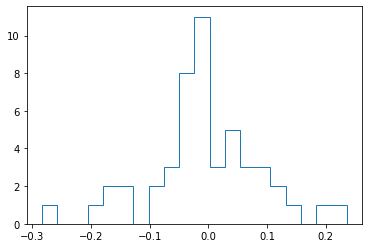

In [185]:
plt.stairs(hist, bins)